# 实证：菲利普斯曲线

PS: when replicating the following result locally, please make sure the data file stays at the correct file path——change it accordingly.

### 一、时间序列图

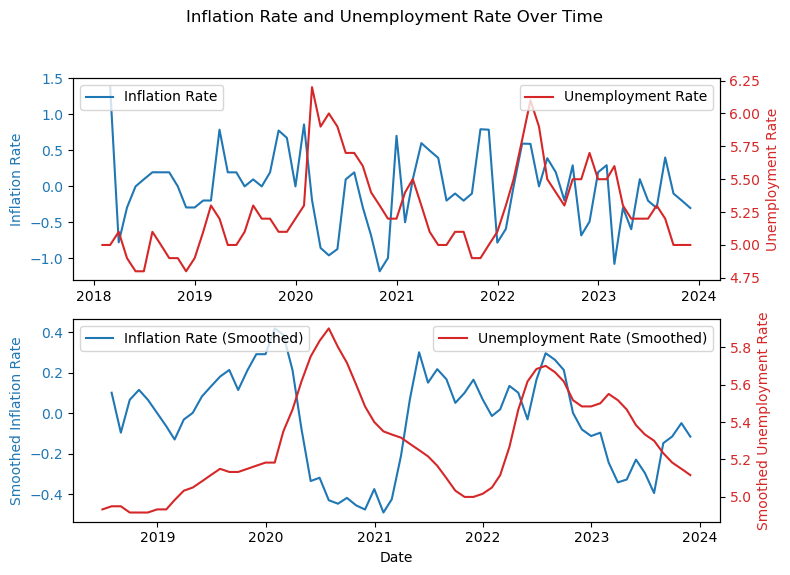

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_excel('/Users/macbookairm1/Desktop/0-DATA.xlsx')

# 设置日期列为datetime类型，并设置为索引
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 计算通货膨胀率（Inflation Rate）
df['InflationRate'] = df['CPI'].pct_change() * 100

# 计算通货膨胀率的移动平均
inflation_window = 6  # 设置通货膨胀率移动平均窗口大小
df['InflationRate_MA'] = df['InflationRate'].rolling(window=inflation_window).mean()

# 计算失业率的移动平均
unemployment_window = 6  # 设置失业率移动平均窗口大小
df['U_MA'] = df['U'].rolling(window=unemployment_window).mean()

# 创建图表布局
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=False)

# 绘制原始通货膨胀率曲线（左轴）
color = 'tab:blue'
ax1.set_ylabel('Inflation Rate', color=color)
ax1.plot(df.index, df['InflationRate'], color=color, label='Inflation Rate')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# 创建右轴
ax1t = ax1.twinx()
color = 'tab:red'
ax1t.set_ylabel('Unemployment Rate', color=color)
ax1t.plot(df.index, df['U'], color=color, label='Unemployment Rate')
ax1t.tick_params(axis='y', labelcolor=color)
ax1t.legend(loc='upper right')

# 绘制平滑后的通货膨胀率曲线（左轴）
color = 'tab:blue'
ax2.set_xlabel('Date')
ax2.set_ylabel('Smoothed Inflation Rate', color=color)
ax2.plot(df.index, df['InflationRate_MA'], color=color, label='Inflation Rate (Smoothed)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')

# 创建右轴
ax2t = ax2.twinx()
color = 'tab:red'
ax2t.set_ylabel('Smoothed Unemployment Rate', color=color)
ax2t.plot(df.index, df['U_MA'], color=color, label='Unemployment Rate (Smoothed)')
ax2t.tick_params(axis='y', labelcolor=color)
ax2t.legend(loc='upper right')

plt.suptitle('Inflation Rate and Unemployment Rate Over Time')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent clipping of suptitle
plt.show()


### 二、平稳检验

In [2]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# 读取数据
df = pd.read_excel('/Users/macbookairm1/Desktop/0-DATA.xlsx')

# 设置日期列为datetime类型，并设置为索引
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 计算通货膨胀率（Inflation Rate）
df['InflationRate'] = df['CPI'].pct_change() * 100

# Drop the first row of the 'U' column to remove the missing value
df['U'] = df['U'].shift(-1).dropna()

# 描述性统计
statistics_df = df[['U', 'InflationRate']].describe()

print(statistics_df)

#检查缺失值
# Drop rows with missing values
df.dropna(subset=['U','InflationRate'], inplace=True)

# 进行单位根检验函数
def adf_test(series, name=""):
    result = adfuller(series, autolag='AIC')
    print(f'\nADF Test for {name}:')
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    if result[1] <= 0.05:
        print("*Reject the null hypothesis. The data is stationary.")
    else:
        print("*Fail to reject the null hypothesis. The data is non-stationary.")
    

# 进行单位根检验
adf_test(df['InflationRate'], name='Inflation Rate')
adf_test(df['U'], name='Unemployment Rate')




               U  InflationRate
count  70.000000      70.000000
mean    5.275714      -0.027096
std     0.325459       0.519382
min     4.800000      -1.179941
25%     5.000000      -0.293758
50%     5.200000       0.000000
75%     5.500000       0.196706
max     6.200000       1.379310

ADF Test for Inflation Rate:
Test Statistic: -4.485019782336482
p-value: 0.00020926579550522849
Critical Values: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
*Reject the null hypothesis. The data is stationary.

ADF Test for Unemployment Rate:
Test Statistic: -2.885935687636862
p-value: 0.04700810027764684
Critical Values: {'1%': -3.5319549603840894, '5%': -2.905755128523123, '10%': -2.5903569458676765}
*Reject the null hypothesis. The data is stationary.


### 四、菲利普斯曲线 & 线性回归

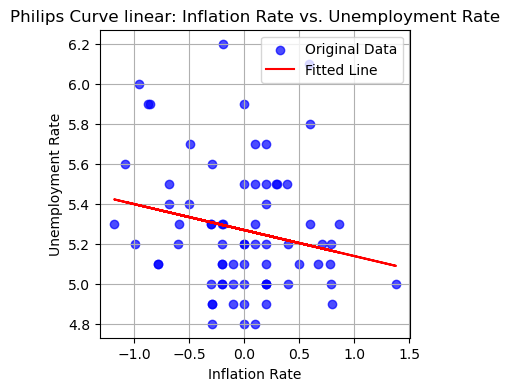

Intercept (a): -0.1299 ± 0.0742
Slope (b): 5.2684 ± 0.0380
Slope (b) is significant.
5.193803598277275 5.342916176868189


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 读取数据
df = pd.read_excel('/Users/macbookairm1/Desktop/0-DATA.xlsx')

# 设置日期列为datetime类型，并设置为索引
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 计算通货膨胀率（Inflation Rate）
df['InflationRate'] = df['CPI'].pct_change() * 100
df['InflationRate'].fillna(0, inplace=True)

# 绘制菲利普斯曲线散点图
plt.figure(figsize=(4, 4))
plt.scatter(df['InflationRate'], df['U'], color='blue', alpha=0.7, label='Original Data')

# 定义一次多项式拟合函数
def linear_fit(x, a, b):
    return a * x + b

# 初始参数估计
params_guess = [0.1, 0.1]

# 使用曲线拟合
popt, pcov = curve_fit(linear_fit, df['InflationRate'], df['U'], p0=params_guess)

# 生成拟合曲线的数据
fit_line = linear_fit(df['InflationRate'], *popt)

# 绘制拟合曲线
plt.plot(df['InflationRate'], fit_line, color='red', label='Fitted Line')

plt.title('Philips Curve linear: Inflation Rate vs. Unemployment Rate')
plt.xlabel('Inflation Rate')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.show()


# 打印拟合参数及其标准差
print(f'Intercept (a): {popt[0]:.4f} ± {np.sqrt(pcov[0, 0]):.4f}')
print(f'Slope (b): {popt[1]:.4f} ± {np.sqrt(pcov[1, 1]):.4f}')

# 计算置信区间
confidence_interval = 1.96 * np.sqrt(pcov[1, 1])
lower_bound = popt[1] - confidence_interval
upper_bound = popt[1] + confidence_interval

# 判断显著性
if lower_bound <= 0 <= upper_bound:
    print("Slope (b) is not significant.")
else:
    print("Slope (b) is significant.")
    
print(lower_bound,upper_bound)

### 其他：对换横纵坐标不显著

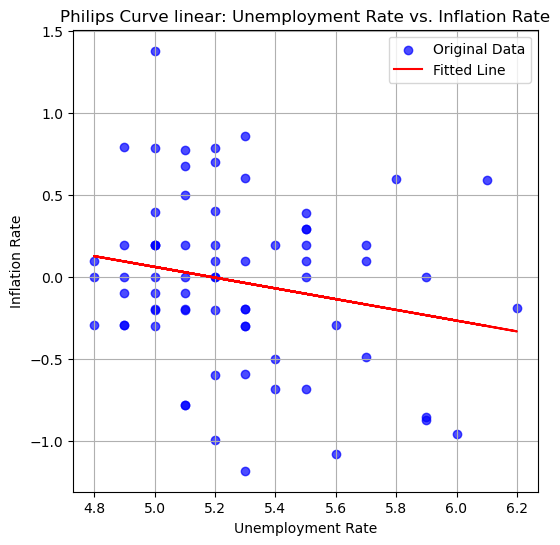

Intercept (a): -0.3276 ± 0.1870
Slope (b): 1.7001 ± 0.9878
Slope (b) is not significant.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 读取数据
df = pd.read_excel('/Users/macbookairm1/Desktop/0-DATA.xlsx')

# 设置日期列为 datetime 类型，并设置为索引
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 计算通货膨胀率（Inflation Rate）
df['InflationRate'] = df['CPI'].pct_change() * 100
df['InflationRate'].fillna(0, inplace=True)

# 绘制菲利普斯曲线散点图，对换坐标轴
plt.figure(figsize=(6, 6))
plt.scatter(df['U'], df['InflationRate'], color='blue', alpha=0.7, label='Original Data')

# 定义一次多项式拟合函数
def linear_fit(x, a, b):
    return a * x + b

# 初始参数估计
params_guess = [0.1, 0.1]

# 使用曲线拟合
popt, pcov = curve_fit(linear_fit, df['U'], df['InflationRate'], p0=params_guess)

# 生成拟合曲线的数据
fit_line = linear_fit(df['U'], *popt)

# 绘制拟合曲线
plt.plot(df['U'], fit_line, color='red', label='Fitted Line')

plt.title('Philips Curve linear: Unemployment Rate vs. Inflation Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Inflation Rate')
plt.legend()
plt.grid(True)
plt.show()

# 打印拟合参数及其标准差
print(f'Intercept (a): {popt[0]:.4f} ± {np.sqrt(pcov[0, 0]):.4f}')
print(f'Slope (b): {popt[1]:.4f} ± {np.sqrt(pcov[1, 1]):.4f}')

# 计算置信区间
confidence_interval = 1.96 * np.sqrt(pcov[1, 1])
lower_bound = popt[1] - confidence_interval
upper_bound = popt[1] + confidence_interval

# 判断显著性
if lower_bound <= 0 <= upper_bound:
    print("Slope (b) is not significant.")
else:
    print("Slope (b) is  significant.")
    


### 其他： 幂律拟合——不显著

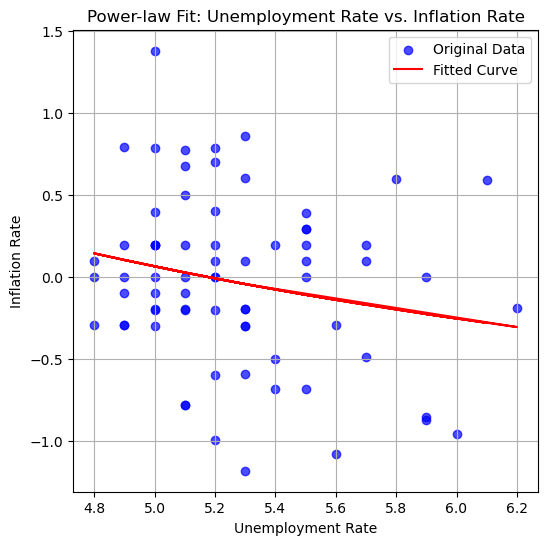

Intercept (a): -1.9082 ± 30.7668
Slope (b): 9.3152 ± 97.7317
Exponent (c): -0.9643 ± 16.2003
Exponent (c) is not significant.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Read data
df = pd.read_excel('/Users/macbookairm1/Desktop/0-DATA.xlsx')

# Set date column as datetime type and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Calculate inflation rate
df['InflationRate'] = df['CPI'].pct_change() * 100
df['InflationRate'].fillna(0, inplace=True)

# Scatter plot of the original data
plt.figure(figsize=(6, 6))
plt.scatter(df['U'], df['InflationRate'], color='blue', alpha=0.7, label='Original Data')

# Define power-law fit function
def power_law_fit(x, a, b, c):
    return a + b * (x ** c)

# Initial parameter guess
params_guess = [0.1, 0.1, 0.1]

# Use curve_fit for power-law fit
popt, pcov = curve_fit(power_law_fit, df['U'], df['InflationRate'], p0=params_guess)

# Generate fitted curve data
fit_curve = power_law_fit(df['U'], *popt)

# Plot the fitted curve
plt.plot(df['U'], fit_curve, color='red', label='Fitted Curve')

plt.title('Power-law Fit: Unemployment Rate vs. Inflation Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Inflation Rate')
plt.legend()
plt.grid(True)
plt.show()

# Print fitted parameters and their standard deviations
print(f'Intercept (a): {popt[0]:.4f} ± {np.sqrt(pcov[0, 0]):.4f}')
print(f'Slope (b): {popt[1]:.4f} ± {np.sqrt(pcov[1, 1]):.4f}')
print(f'Exponent (c): {popt[2]:.4f} ± {np.sqrt(pcov[2, 2]):.4f}')

# Calculate confidence interval for the exponent
confidence_interval = 1.96 * np.sqrt(pcov[2, 2])
lower_bound = popt[2] - confidence_interval
upper_bound = popt[2] + confidence_interval

# Check significance of the exponent
if lower_bound <= 0 <= upper_bound:
    print("Exponent (c) is not significant.")
else:
    print("Exponent (c) is significant.")


### 其他：有问题的幂律拟合

/Users/macbookairm1/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


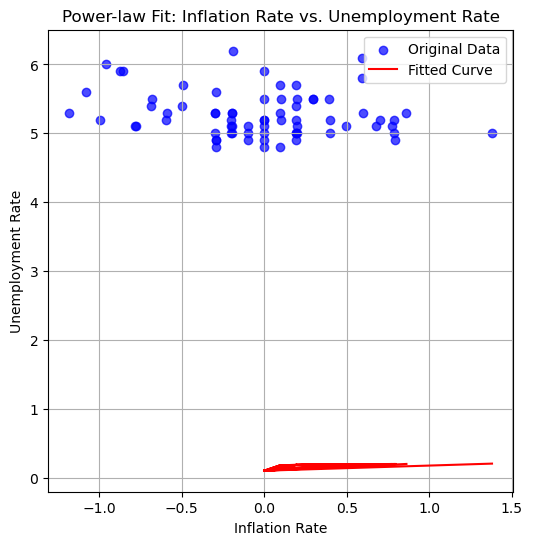

Intercept (a): 0.1000 ± inf
Slope (b): 0.1000 ± inf
Exponent (c): 0.1000 ± inf
Exponent (c) is not significant.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Read data
df = pd.read_excel('/Users/macbookairm1/Desktop/0-DATA.xlsx')

# Set date column as datetime type and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Calculate inflation rate
df['InflationRate'] = df['CPI'].pct_change() * 100
df['InflationRate'].fillna(0, inplace=True)

# Scatter plot with swapped axes
plt.figure(figsize=(6, 6))
plt.scatter(df['InflationRate'], df['U'], color='blue', alpha=0.7, label='Original Data')  # Swap x and y

# Define power-law fit function
def power_law_fit(x, a, b, c):
    return a + b * (x ** c)

# Initial parameter guess
params_guess = [0.1, 0.1, 0.1]

# Use curve_fit for power-law fit with swapped axes
popt, pcov = curve_fit(power_law_fit, df['InflationRate'], df['U'], p0=params_guess)  # Swap x and y

# Generate fitted curve data
fit_curve = power_law_fit(df['InflationRate'], *popt)  # Swap x

# Plot the fitted curve
plt.plot(df['InflationRate'], fit_curve, color='red', label='Fitted Curve')  # Swap x

plt.title('Power-law Fit: Inflation Rate vs. Unemployment Rate')  # Swap x and y labels
plt.xlabel('Inflation Rate')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.show()

# Print fitted parameters and their standard deviations
print(f'Intercept (a): {popt[0]:.4f} ± {np.sqrt(pcov[0, 0]):.4f}')
print(f'Slope (b): {popt[1]:.4f} ± {np.sqrt(pcov[1, 1]):.4f}')
print(f'Exponent (c): {popt[2]:.4f} ± {np.sqrt(pcov[2, 2]):.4f}')

# Calculate confidence interval for the exponent
confidence_interval = 1.96 * np.sqrt(pcov[2, 2])
lower_bound = popt[2] - confidence_interval
upper_bound = popt[2] + confidence_interval

# Check significance of the exponent
if lower_bound <= 0 <= upper_bound:
    print("Exponent (c) is not significant.")
else:
    print("Exponent (c) is significant.")


### 其他：折线图

   NUM       date    U    CPI  InflationRate
0    1 2018-01-31  5.0  101.5            NaN
1    2 2018-02-28  5.0  102.9       1.379310
2    3 2018-03-31  5.1  102.1      -0.777454
3    4 2018-04-30  4.9  101.8      -0.293830
4    5 2018-05-31  4.8  101.8       0.000000


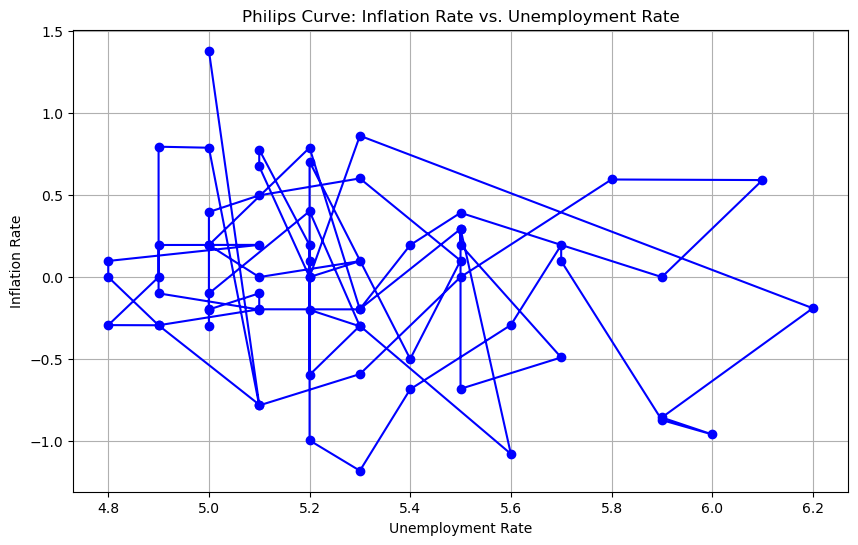

In [7]:
import pandas as pd
import numpy as np

# 读取Excel文件
df = pd.read_excel('/Users/macbookairm1/Desktop/0-DATA.xlsx')

# 计算通货膨胀率（Inflation Rate）
df['InflationRate'] = df['CPI'].pct_change() * 100

# 打印数据前几行，检查计算结果
print(df.head())

import matplotlib.pyplot as plt

# 绘制菲利普斯曲线1--折线图
plt.figure(figsize=(10, 6))
plt.plot(df['U'], df['InflationRate'], marker='o', linestyle='-', color='blue')
plt.title('Philips Curve: Inflation Rate vs. Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Inflation Rate')
plt.grid(True)
plt.show()

###  其他：VAR & 脉冲响应函数分析_不显著

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, Feb, 2024
Time:                     09:13:11
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.58676
Nobs:                     68.0000    HQIC:                  -4.70500
Log likelihood:          -24.3674    FPE:                 0.00837521
AIC:                     -4.78259    Det(Omega_mle):      0.00768239
--------------------------------------------------------------------
Results for equation U
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.891062         0.366270            2.433           0.015
L1.U                     0.830990         0.069207           12.007           0.000
L1.InflationRate        -0.023636         0.043025  

/Users/macbookairm1/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


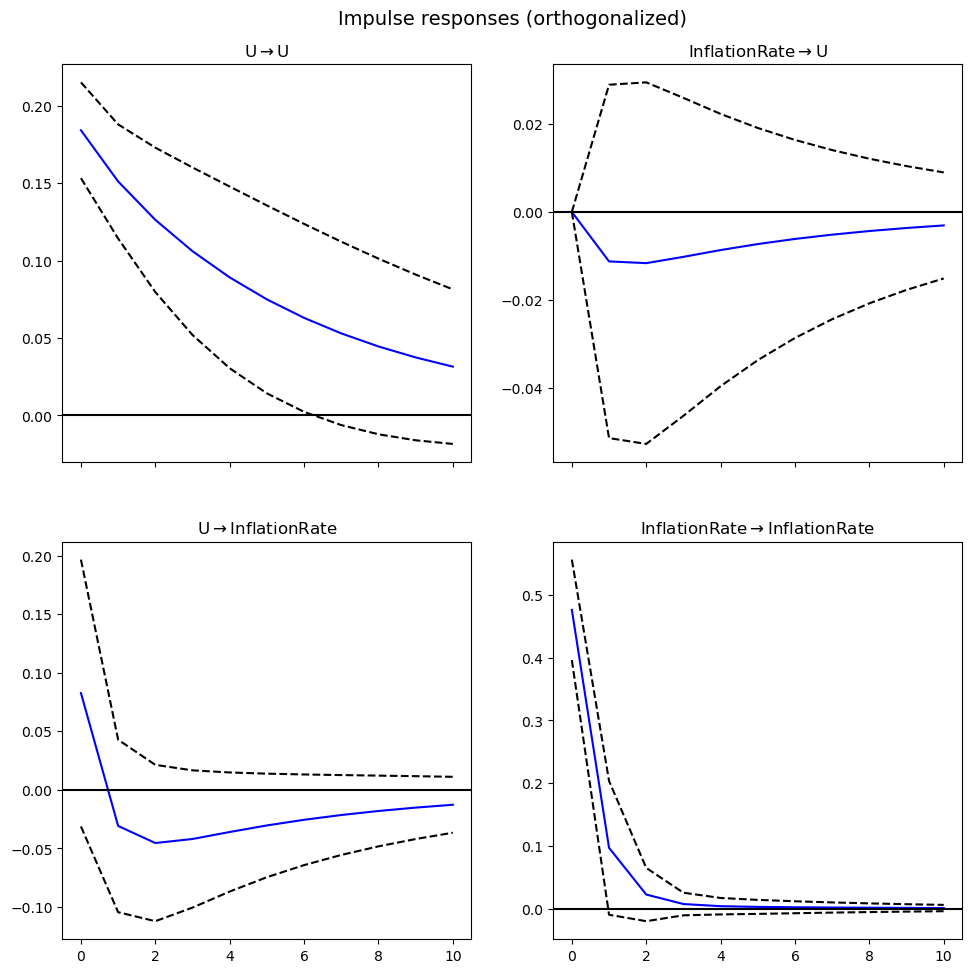

In [8]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR


# 读取数据
df = pd.read_excel('/Users/macbookairm1/Desktop/0-DATA.xlsx')

# 设置日期列为datetime类型，并设置为索引
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 计算通货膨胀率（Inflation Rate）
df['InflationRate'] = df['CPI'].pct_change() * 100

# Drop the first row of the 'U' column to remove the missing value
df['U'] = df['U'].shift(-1).dropna()



#检查缺失值
# Drop rows with missing values
df.dropna(subset=['U','InflationRate'], inplace=True)




# Perform VAR analysis
model = VAR(df[['U', 'InflationRate']])
results = model.fit()

# Print VAR summary
print(results.summary())

# Impulse response analysis
irf = results.irf(10)  # Set the number of periods for the impulse response function
irf.plot(orth=True)
plt.show()
